In [1]:
cd ..

/project/6006178/dongxx


In [2]:
cd twitter_baseline

/project/6006178/dongxx/twitter_baseline


In [3]:
import config
config.seed_torch()
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchtext.vocab import GloVe,Vocab,Vectors
from tqdm import tqdm
from utils import Twitter_indexing, pad_sequenc,pad_sequencing
from models import CNN_Baseline,LSTM_atten,BERTGRUSentiment
from bert_baseline import validate, prepare_dateset,generate_batch
from bert_train import epoch_time
import torchtext.vocab
import csv
import pandas as pd
import argparse
import logging
import os
import pickle
import sys
import config
config.seed_torch()
from collections import Counter
import time
import copy

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [5]:
test = '/home/dongxx/projects/def-parimala/dongxx/data140/test.csv'
valid = '/home/dongxx/projects/def-parimala/dongxx/data140/valid.csv'
train ='/home/dongxx/projects/def-parimala/dongxx/data140/train.csv'

In [6]:
from transformers import BertTokenizer, BertModel

In [7]:
 bert = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
train_dataset, validation_dataset,test_dataset,labellist = prepare_dateset(train, valid,test)
testing = DataLoader(test_dataset, collate_fn= generate_batch, batch_size=128, shuffle=False)
BertGRU_model = BERTGRUSentiment(bert,
                                     config.HIDDEN_DIM,
                                     config.OUTPUT_DIM,
                                     config.N_LAYERS,
                                     config.BIDIRECTIONAL,
                                     config.DROPOUT)
BertGRU_model.to(device)

criterion = nn.CrossEntropyLoss()
criterion.to(device)
BertGRU_model.load_state_dict(torch.load(config.BERT_Tiwtter_ft_PATH))

Start loading training data
Finish loading training data
Start loading validation data
Finish loading validation data
Start loading testing data
Finish loading testing data
prepare training and test sets


<All keys matched successfully>

In [9]:
start_time = time.time()
test_loss, test_acc,flat_list = validate(testing,BertGRU_model,criterion,device)
end_time = time.time()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)
print(f' | Epoch Time: {epoch_mins}m {epoch_secs}s')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


 | Epoch Time: 5m 40s


In [17]:
pred_list =[item.cpu().numpy() for sublist in flat_list for item in sublist]

In [18]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

Test Loss: 0.327 | Test Acc: 86.01%


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import itertools

In [20]:
import matplotlib.pyplot as plt
import itertools

In [21]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

[[0.863425 0.136575]
 [0.14325  0.85675 ]]


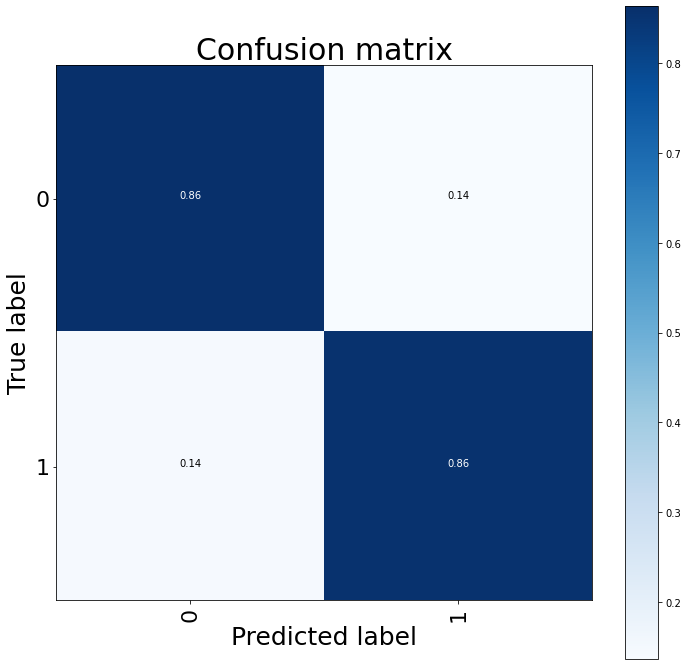

In [22]:
cnf_matrix = confusion_matrix(labellist, pred_list)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=[0,1], title="Confusion matrix")
plt.show()

In [23]:
print(classification_report(labellist, pred_list,digits = 4))

              precision    recall  f1-score   support

           0     0.8577    0.8634    0.8606     80000
           1     0.8625    0.8568    0.8596     80000

    accuracy                         0.8601    160000
   macro avg     0.8601    0.8601    0.8601    160000
weighted avg     0.8601    0.8601    0.8601    160000

